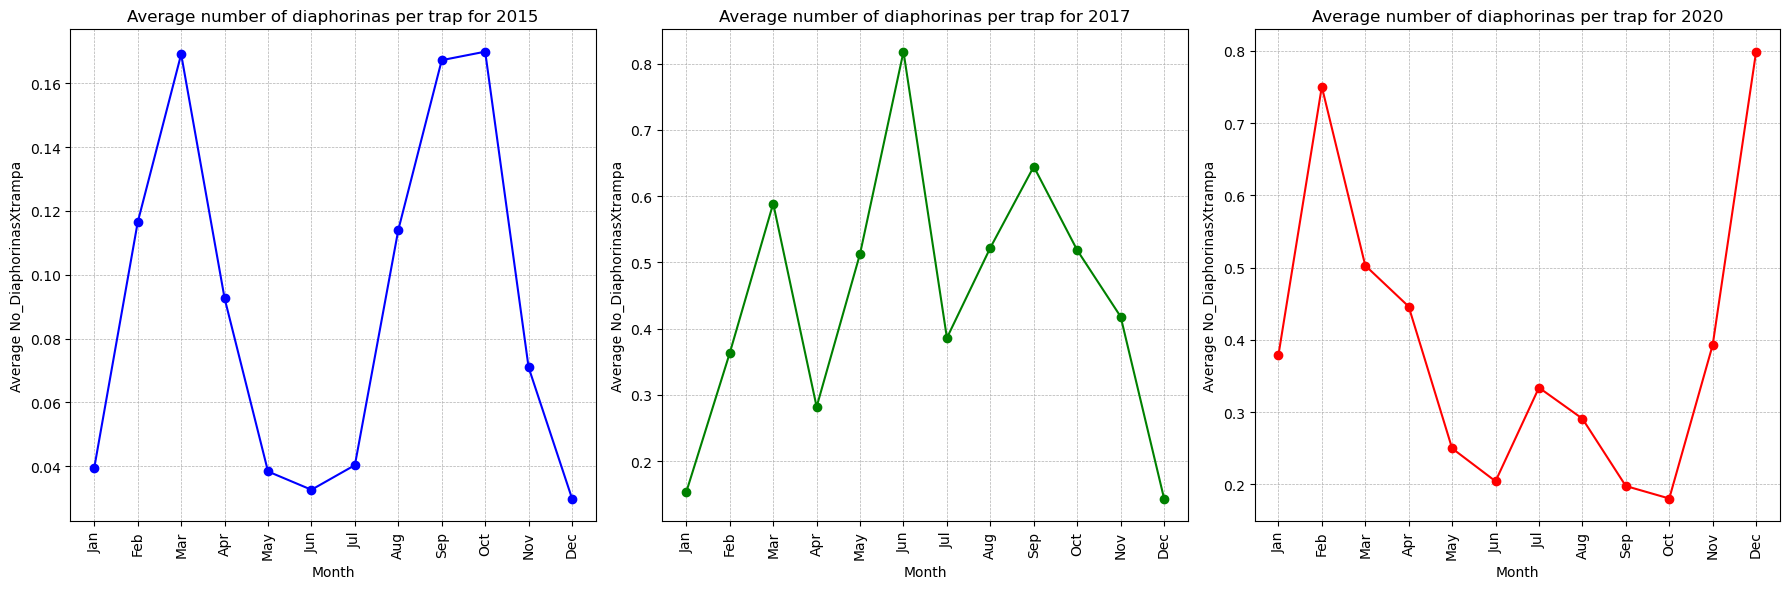

In [3]:
# PROBLEMA 1

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, year
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder.appName("DiaphorinasAnalysis").getOrCreate()
df = spark.read.csv('dataset_limpio.csv', header=True, inferSchema=True)

df = df.withColumn('Year', year(col('Fecha')))

df_2015 = df.filter(col('Year') == 2015)
df_2017 = df.filter(col('Year') == 2017)
df_2020 = df.filter(col('Year') == 2020)

df_2015_monthly = df_2015.groupBy('Month').agg(mean('No_DiaphorinasXtrampa').alias('Average_No_DiaphorinasXtrampa')).orderBy('Month')
df_2017_monthly = df_2017.groupBy('Month').agg(mean('No_DiaphorinasXtrampa').alias('Average_No_DiaphorinasXtrampa')).orderBy('Month')
df_2020_monthly = df_2020.groupBy('Month').agg(mean('No_DiaphorinasXtrampa').alias('Average_No_DiaphorinasXtrampa')).orderBy('Month')

df_2015_monthly_pd = df_2015_monthly.toPandas()
df_2017_monthly_pd = df_2017_monthly.toPandas()
df_2020_monthly_pd = df_2020_monthly.toPandas()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(df_2015_monthly_pd['Month'], df_2015_monthly_pd['Average_No_DiaphorinasXtrampa'], marker='o', color='b')
plt.title('Average number of diaphorinas per trap for 2015')
plt.xlabel('Month')
plt.ylabel('Average No_DiaphorinasXtrampa')
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplot(1, 3, 2)
plt.plot(df_2017_monthly_pd['Month'], df_2017_monthly_pd['Average_No_DiaphorinasXtrampa'], marker='o', color='g')
plt.title('Average number of diaphorinas per trap for 2017')
plt.xlabel('Month')
plt.ylabel('Average No_DiaphorinasXtrampa')
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplot(1, 3, 3)
plt.plot(df_2020_monthly_pd['Month'], df_2020_monthly_pd['Average_No_DiaphorinasXtrampa'], marker='o', color='r')
plt.title('Average number of diaphorinas per trap for 2020')
plt.xlabel('Month')
plt.ylabel('Average No_DiaphorinasXtrampa')
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

spark.stop()


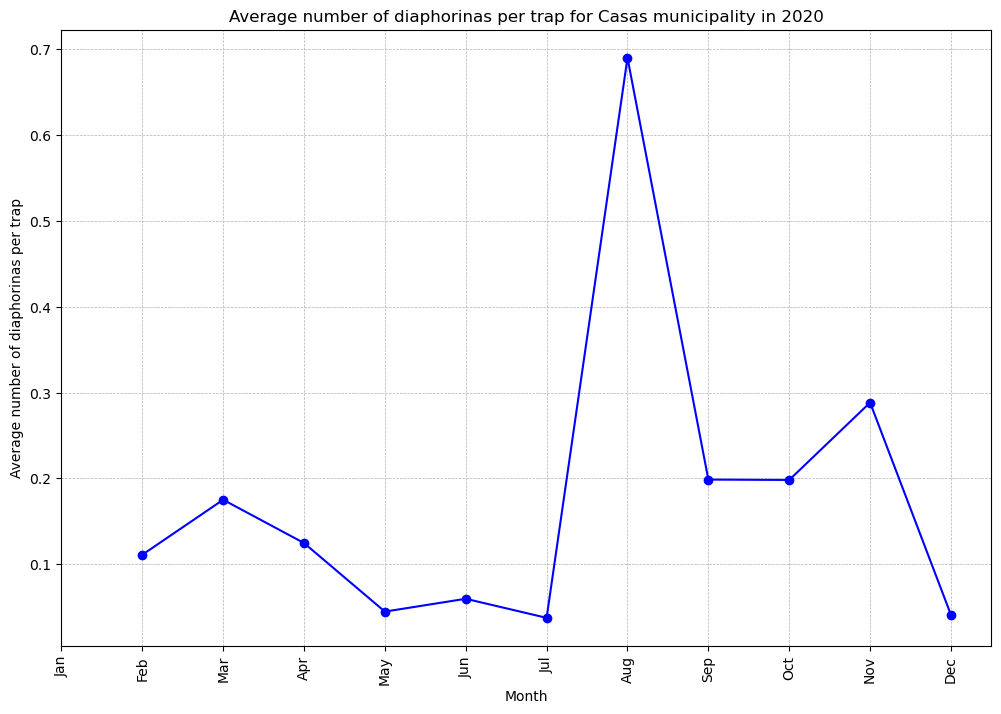

In [16]:
# PROBLEMA 2
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("DiaphorinasCasasAnalysis") \
    .getOrCreate()

df = spark.read.csv("capturas_2020.csv", header=True, inferSchema=True)

casas = df.filter(col('Municipio') == 'CASAS')
casas_monthly = casas.groupBy('Mes').agg(mean('No_DiaphorinasXtrampa').alias('Average_No_DiaphorinasXtrampa')).orderBy('Mes')

casas_monthly_pd = casas_monthly.toPandas()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 8))
plt.plot(casas_monthly_pd['Mes'], casas_monthly_pd['Average_No_DiaphorinasXtrampa'], marker='o', color='b')
plt.title('Average number of diaphorinas per trap for Casas municipality in 2020')
plt.xlabel('Month')
plt.ylabel('Average number of diaphorinas per trap')
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

spark.stop()


In [17]:
# PROBLEMA 3
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, variance, sum as spark_sum
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("DiaphorinasSummary") \
    .getOrCreate()

sheet_2015 = spark.read.csv("capturas_y2015.csv", header=True, inferSchema=True)
sheet_2015 = sheet_2015.withColumn('Fecha', F.to_date(col('Fecha'), 'yyyy-MM-dd'))

data = []

for month in range(1, 13):
    month_data = sheet_2015.filter(col('Mes') == month)
    monthly_means = month_data.groupBy('Ubicacion').agg(mean('No_DiaphorinasXtrampa').alias('Average_No_Diaphorinas'))

    for row in monthly_means.collect():
        data.append({'Mes': month, 'Ubicacion': row['Ubicacion'], 'Average_No_Diaphorinas': row['Average_No_Diaphorinas']})

placeholder = spark.createDataFrame(data)

coef_disp = placeholder.groupBy('Mes').agg((variance('Average_No_Diaphorinas') / mean('Average_No_Diaphorinas')).alias('Indice de dispersion'))
coef_cx = placeholder.groupBy('Mes').agg(((variance('Average_No_Diaphorinas') / mean('Average_No_Diaphorinas') - 1) / (spark_sum('Average_No_Diaphorinas') - 1)).alias('Coeficiente de Green'))

monthly_summary = coef_disp.join(coef_cx, on='Mes', how='outer')
monthly_summary.show(20)

spark.stop()


+---+--------------------+--------------------+
|Mes|Indice de dispersion|Coeficiente de Green|
+---+--------------------+--------------------+
|  1|  0.9834137407308141|-0.00438403328700...|
|  2|   1.300030506748239|3.304604021091204...|
|  3|  1.8225820673593196|6.560973618020495E-4|
|  4|  0.8705314199420938|-1.57581037071453...|
|  5|   0.766091640551763|-8.10774209525951...|
|  6|   1.436828958772476|0.001701378612551...|
|  7|  1.6119562839881454|0.002006414045862775|
|  8|  2.6796452880292403|0.001877747666885...|
|  9|   3.118736821800194|0.001740592993879806|
| 10|    4.22905590638433|0.002381397475116...|
| 11|   2.043487232756671|0.001644797949964...|
| 12|  2.1286582175318296|0.004011105434573836|
+---+--------------------+--------------------+



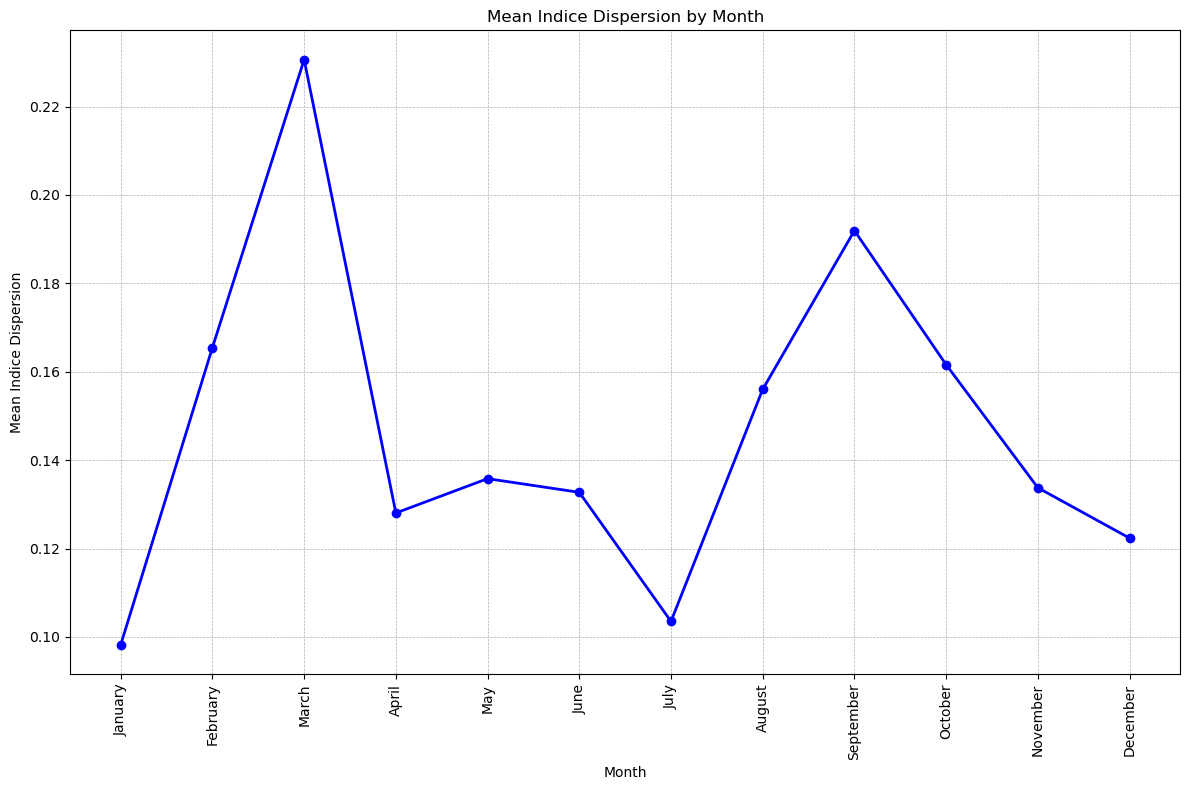

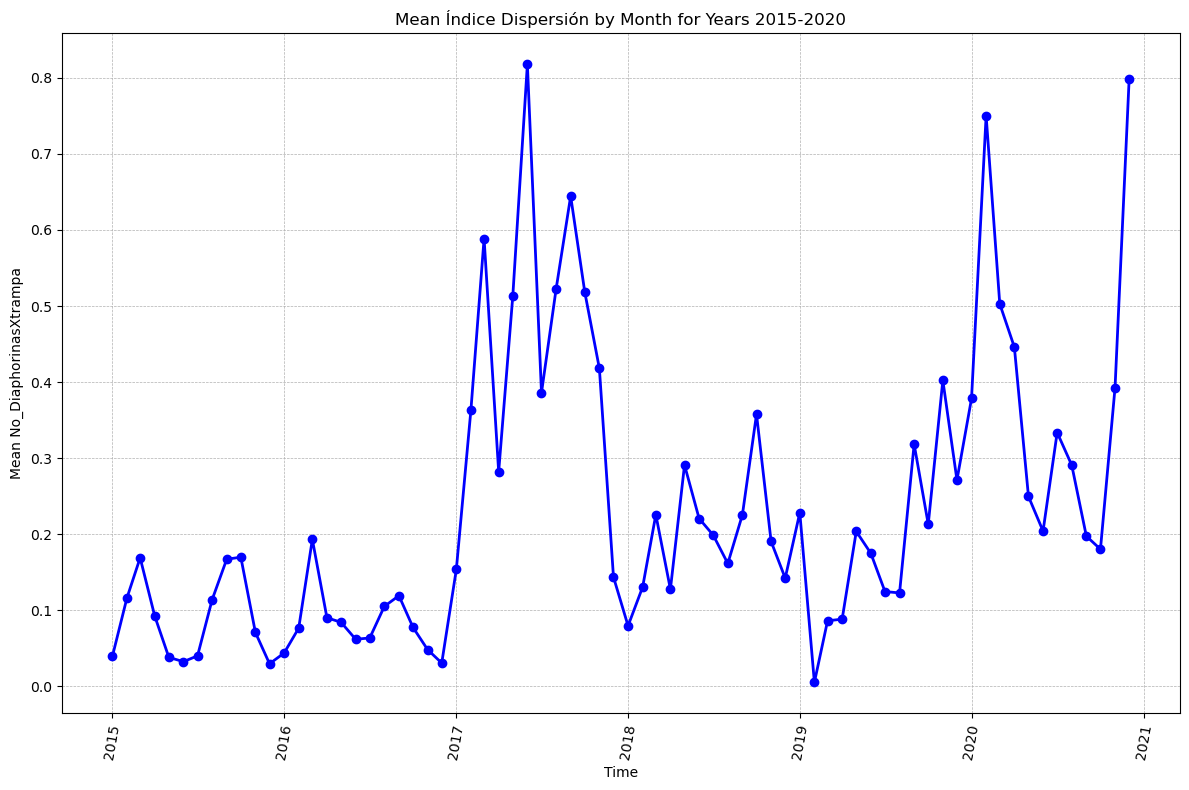

In [29]:
#PROBLEMA 4
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, month, year, to_date, concat, lit, lpad
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("MeanIndiceDispersion") \
    .getOrCreate()

capturas = spark.read.csv("dataset_limpio.csv", header=True, inferSchema=True)
capturas = capturas.withColumn('Fecha', to_date(col('Fecha'), 'yyyy-MM-dd'))

capturas_monthly = capturas.groupBy(month('Fecha').alias('Month')).agg(mean('No_DiaphorinasXtrampa').alias('Mean_No_DiaphorinasXtrampa'))

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

capturas_monthly_pd = capturas_monthly.toPandas()
capturas_monthly_pd = capturas_monthly_pd.sort_values('Month')  # Sort by Month

plt.figure(figsize=(12, 8))
plt.plot(capturas_monthly_pd['Month'], capturas_monthly_pd['Mean_No_DiaphorinasXtrampa'], marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Mean Indice Dispersion by Month')
plt.xlabel('Month')
plt.ylabel('Mean Indice Dispersion')
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

capturas = capturas.withColumn('Year', year('Fecha')).withColumn('Month', month('Fecha'))

capturas_continuous = capturas.groupBy('Year', 'Month').agg(mean('No_DiaphorinasXtrampa').alias('Mean_No_DiaphorinasXtrampa'))

capturas_continuous = capturas_continuous.withColumn('Time', 
    to_date(concat(col('Year').cast('string'), lit('-'), 
    lpad(col('Month').cast('string'), 2, '0'))))

capturas_continuous = capturas_continuous.orderBy('Time') 
capturas_continuous_pd = capturas_continuous.toPandas()

plt.figure(figsize=(12, 8))
plt.plot(capturas_continuous_pd['Time'], capturas_continuous_pd['Mean_No_DiaphorinasXtrampa'], marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Mean Índice Dispersión by Month for Years 2015-2020')
plt.xlabel('Time')
plt.ylabel('Mean No_DiaphorinasXtrampa')
plt.xticks(rotation=80)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

spark.stop()


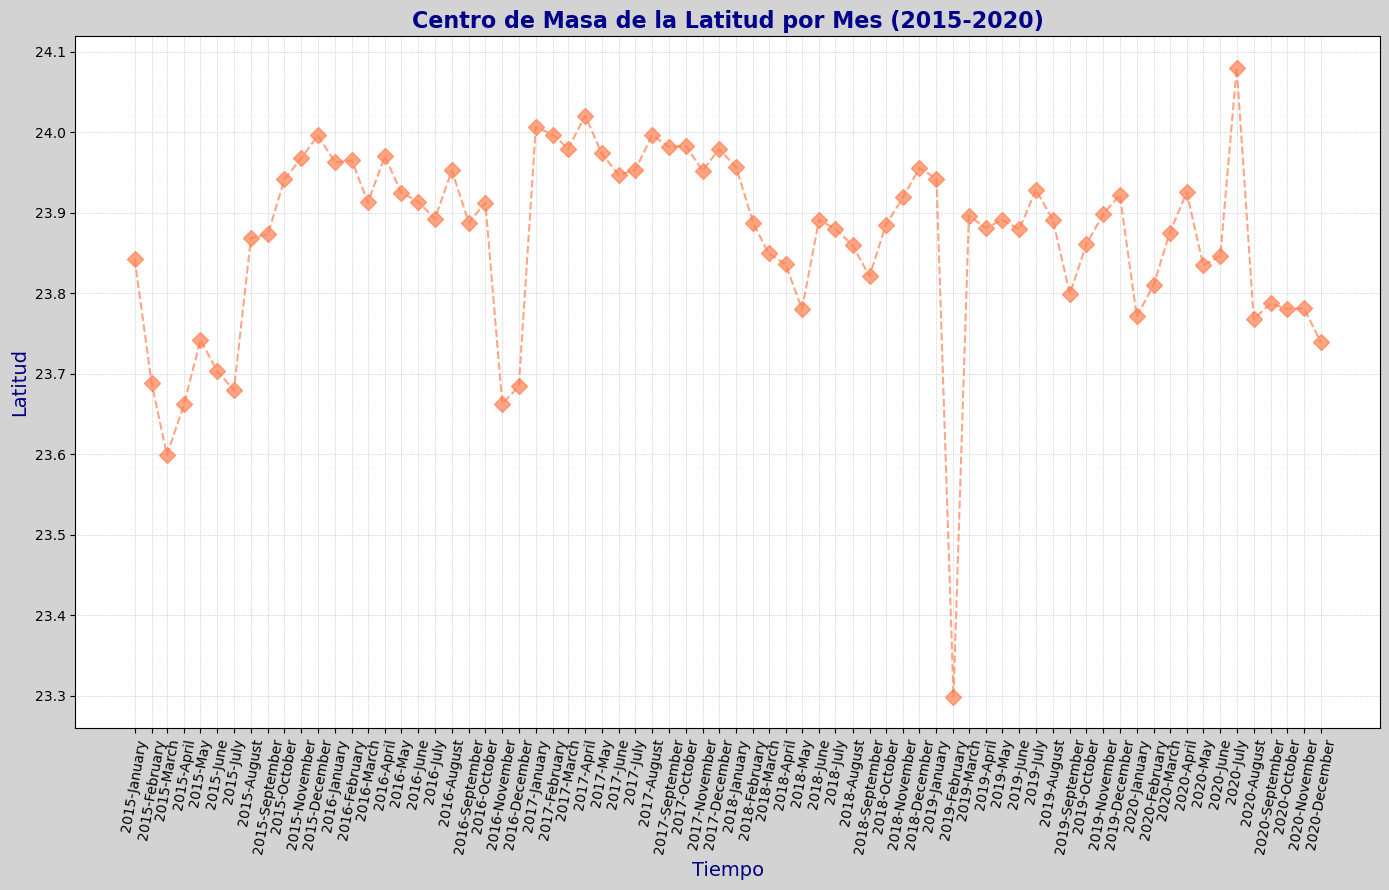

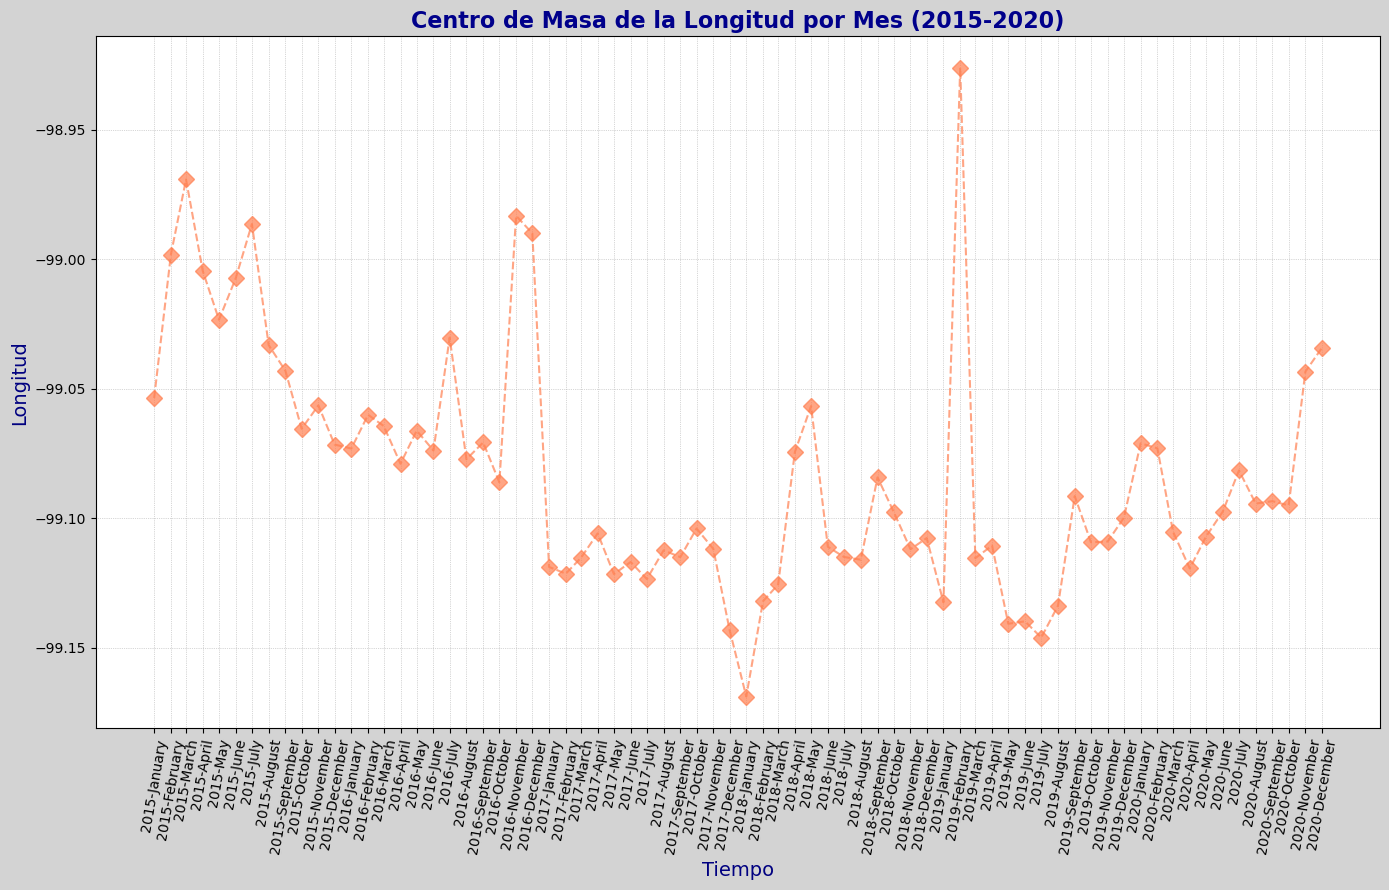

In [34]:
#PROBLEMA 5
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, month, year, to_date, sum as spark_sum
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder \
    .appName("MassCenterAnalysis") \
    .getOrCreate()

capturas = spark.read.csv("dataset_limpio.csv", header=True, inferSchema=True)
capturas = capturas.withColumn('Fecha', to_date(col('Fecha'), 'yyyy-MM-dd'))

capturas = capturas.withColumn('Mes', month('Fecha')).withColumn('Año', year('Fecha'))

grouped_data = capturas.groupBy('Año', 'Mes').agg(
    spark_sum('No_DiaphorinasXtrampa').alias('Total_No_DiaphorinasXtrampa'),
    (spark_sum(col('No_DiaphorinasXtrampa') * col('Latitud')) / spark_sum('No_DiaphorinasXtrampa')).alias('Centro_Latitud'),
    (spark_sum(col('No_DiaphorinasXtrampa') * col('Longitud')) / spark_sum('No_DiaphorinasXtrampa')).alias('Centro_Longitud')
)

grouped_data_pd = grouped_data.toPandas()

grouped_data_pd['Tiempo'] = pd.to_datetime(grouped_data_pd['Año'].astype(str) + '-' + grouped_data_pd['Mes'].astype(str).str.zfill(2))
grouped_data_pd = grouped_data_pd.sort_values('Tiempo')

def create_time_series(data_frame, value_column, title, ylabel):
    fig, ax = plt.subplots(figsize=(14, 9), facecolor='lightgrey')
    
    ax.plot(data_frame['Tiempo'], data_frame[value_column], marker='D', linestyle='--', color='coral', markersize=8, alpha=0.7)
    
    ax.set_title(title, fontsize=16, fontweight='bold', color='darkblue')
    ax.set_xlabel('Tiempo', fontsize=14, color='navy')
    ax.set_ylabel(ylabel, fontsize=14, color='navy')
    ax.tick_params(axis='x', rotation=80)
    
    month_labels = data_frame['Año'].astype(str) + '-' + data_frame['Mes'].apply(lambda x: month_names[x-1])
    ax.set_xticks(data_frame['Tiempo'])
    ax.set_xticklabels(month_labels, fontsize=10, color='black')
    
    ax.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

create_time_series(grouped_data_pd, 'Centro_Latitud', 'Centro de Masa de la Latitud por Mes (2015-2020)', 'Latitud')
create_time_series(grouped_data_pd, 'Centro_Longitud', 'Centro de Masa de la Longitud por Mes (2015-2020)', 'Longitud')

spark.stop()
